In [2]:
import torch
import torch.nn as nn
import pandas as pd

In [3]:
# Define la estructura del modelo

# Model definition
dropout_rate = 0.5
number_raster_layers = 9
number_pixels_layer = 19

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv1 = nn.Conv2d(number_raster_layers, 16, kernel_size=3, stride=1, padding=1)
        self.selu1 = nn.SELU()
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.selu2 = nn.SELU()
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.selu3 = nn.SELU()
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.selu4 = nn.SELU()
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.selu5 = nn.SELU()
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.selu6 = nn.SELU()
        # self.dropout = nn.Dropout(dropout_rate)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512 * number_pixels_layer * number_pixels_layer, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.selu1(x)
        x = self.conv2(x)
        x = self.selu2(x)
        x = self.conv3(x)
        x = self.selu3(x)
        x = self.conv4(x)
        x = self.selu4(x)
        x = self.conv5(x)
        x = self.selu5(x)
        x = self.conv6(x)
        x = self.selu6(x)
        x = self.flatten(x)
        # x = self.dropout(x)
        x = self.fc(x)
        return x

model = CNNRegressor()

In [4]:
# Load model
path_model = 'Data/Calibrated_models/global_regressor_V0.pth'
model.load_state_dict(torch.load(path_model))



<All keys matched successfully>

In [5]:
# Cambia el modelo al modo de evaluación (si es necesario)
model.eval()

CNNRegressor(
  (conv1): Conv2d(9, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu1): SELU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu2): SELU()
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu3): SELU()
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu4): SELU()
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu5): SELU()
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (selu6): SELU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=184832, out_features=1, bias=True)
)

In [20]:
# Load tensors
path_tensor_train = 'Data/Calibrated_models/global_regressor_V0_tensor_y_train.pth'
y_train = torch.load(path_tensor_train)

path_tensor_test = 'Data/Calibrated_models/global_regressor_V0_tensor_y_test.pth'
y_test = torch.load(path_tensor_test)

path_tensor_test = 'Data/Calibrated_models/global_regressor_V0_test_tensor.pth'
test_tensor = torch.load(path_tensor_test)

path_tensor_training = 'Data/Calibrated_models/global_regressor_V0_training_tensor.pth'
training_tensor = torch.load(path_tensor_training)

In [7]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from scipy.stats import spearmanr

# Model eval
y_pred = model(test_tensor.to(torch.float))
y_true = y_test.to(torch.float)

# MSE
mse = nn.MSELoss()
mse_loss = mse(y_pred, y_true)
print("MSE:", mse_loss.item())

# RMSE
rmse_loss = torch.sqrt(mse_loss)
print("RMSE:", rmse_loss.item())

# MAE
mae_loss = torch.mean(torch.abs(y_pred - y_true))
print("MAE:", mae_loss.item())

y_true_array = y_true.flatten().tolist()
y_pred_array = y_pred.flatten().tolist()

# R^2
r2 = r2_score(y_true_array, y_pred_array)
print("R^2:", r2)

# Pearson
corr, p_value_r = pearsonr(y_true_array, y_pred_array)
print("Pearson's r:", corr)
print("p-value (Pearson):", p_value_r)
print("Sanity check: r * r?", corr*corr)
print("Sanity check: r2 - r * r = 0?", r2 == corr*corr, r2 - corr*corr)

# Spearman
rho, p_value_rho = spearmanr(y_true_array, y_pred_array)
print("Spearman's rho:", rho)
print("p-value:", p_value_rho)

MSE: 2.108320951461792
RMSE: 1.4520058631896973
MAE: 1.1913878917694092
R^2: 0.12594198646820398
Pearson's r: 0.41490658905007916
p-value (Pearson): 1.8501715378295973e-08
Sanity check: r * r? 0.17214747763717125
Sanity check: r2 - r * r = 0? False -0.04620549116896727
Spearman's rho: 0.4399167953903466
p-value: 1.944268783242885e-09


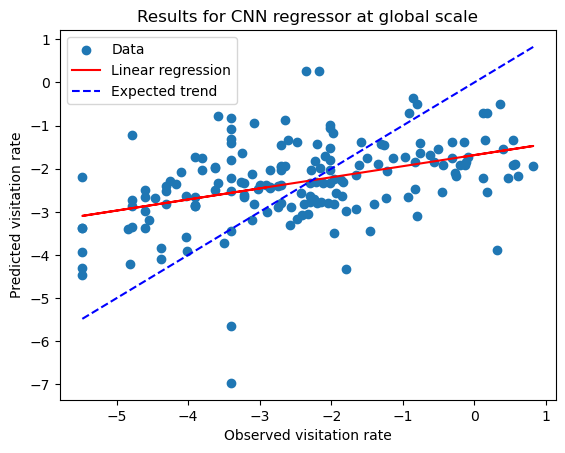

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# fit a regression line with numpy
coef = np.polyfit(y_true_array, y_pred_array, 1)
poly1d_fn = np.poly1d(coef)

# create a scatter plot with regression line
plt.scatter(y_true_array, y_pred_array, label='Data')
plt.plot(y_true_array, poly1d_fn(y_true_array), color = 'red', label = 'Linear regression')
plt.plot(sorted(y_true_array), sorted(y_true_array), color = 'blue', linestyle = '--', label = 'Expected trend')

# Add labels
plt.xlabel('Observed visitation rate')
plt.ylabel('Predicted visitation rate')
plt.title('Results for CNN regressor at global scale')

# show legend
plt.legend()

# show plot
plt.show()

In [9]:
# Add model predictions to training and test sets

# Load training and test info

df_train = pd.read_csv('Data/data_train_new.csv')
df_test = pd.read_csv('Data/data_test_new.csv')

rows_with_na = df_test.isna().any(axis=1)
indices_na = df_test.index[rows_with_na]
df_test = df_test.drop(index=indices_na)

In [15]:
# Model results for test partition
y_pred = model(test_tensor.to(torch.float))
# Turn the tensor into a NumPy array
y_pred_numpy_array = y_pred.detach().numpy()

# create a pandas series from NumPy array
y_pred_pandas_serie = pd.Series(y_pred_numpy_array.squeeze(), name='global_regressor_V0')
df_test['global_regressor_V0'] = y_pred_pandas_serie

# Save info
df_test.to_csv('Data/data_test_global_regressor_V0.csv', index=False)

In [33]:
# Model results for train partition
y_train_predicted = model(training_tensor.to(torch.float))
# Turn the tensor into a NumPy array
y_train_predicted_numpy_array = y_train_predicted.detach().numpy()

# Select elements in positions: 0, 4, 8, 12, ...
indices = np.arange(0, len(y_train_predicted_numpy_array), 4)
y_train_predicted_numpy_array_filtered = y_train_predicted_numpy_array[indices]

# create a pandas series from NumPy array
y_train_predicted_pandas_serie = pd.Series(y_train_predicted_numpy_array_filtered.squeeze(), name='global_regressor_V0')
df_train['global_regressor_V0'] = y_train_predicted_pandas_serie

# Save info
df_train.to_csv('Data/data_train_global_regressor_V0.csv', index=False)